In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [6]:
ts = pd.read_csv('../data/PJMW_hourly.csv', index_col=[0], parse_dates=[0])

In [7]:
ts.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


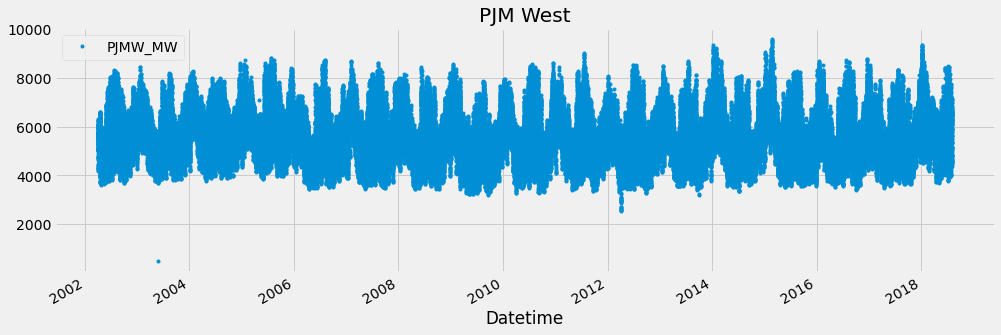

In [13]:
ts.plot(style='.', figsize=(15,5), title='PJM West')
plt.show()

In [11]:
# find the index which allows us to split off 20% of the data
split_date = '01-Jan-2015'
train = ts.loc[ts.index <= split_date].copy()
test = ts.loc[ts.index > split_date].copy()

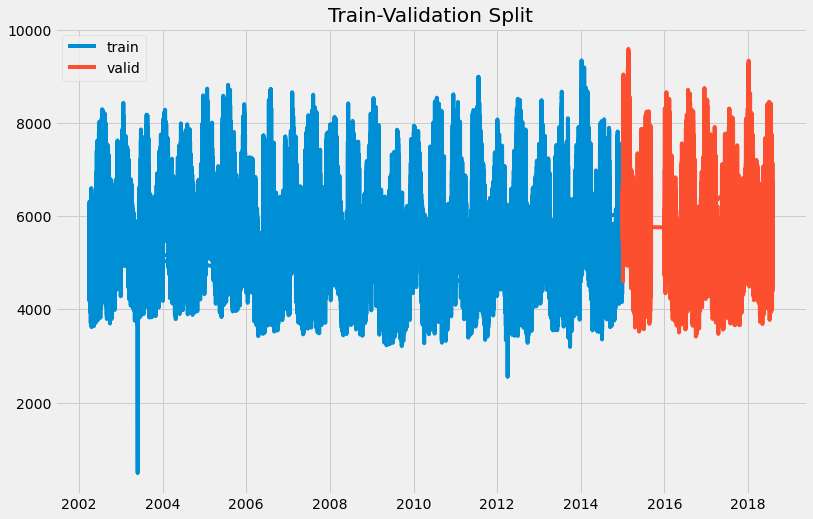

In [12]:
# Define train and test sets according to the index found above

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train, label='train')
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

Baseline